In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.linear_solver import pywraplp
import random
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 500

In [2]:
DIVERSITY_UTILITY = 0.25
FRAC_ADMIT = 0.5


###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test.csv')
df['key'] = df['R'].astype(str) + "_"  + df['T'].astype(str)

###
## Estimate E[Y(1)|T, A]
###

df_train = pd.read_csv('./df_train.csv')
df_stratum_utility = df_train[['R','T','B_p']].groupby(['R','T']).mean().reset_index()
df_stratum_utility['stratum_utility'] = (df_stratum_utility['B_p'] + DIVERSITY_UTILITY * df_stratum_utility['R']).round(2)
df_stratum_utility['key'] = df_stratum_utility['R'].astype(str) + "_" + df_stratum_utility['T'].astype(str)

df = df.merge(df_stratum_utility[['stratum_utility','key']], on='key')
df['ml_outcomes'] = df['stratum_utility']

In [3]:
FRAC_ADMIT = 0.5#df[['A']].sum()/len(df)


In [4]:
FRAC_ADMIT

0.5

In [5]:
len(df)

100000

<AxesSubplot:>

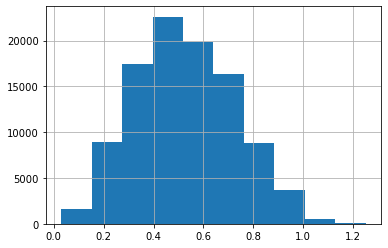

In [6]:
df['ml_outcomes'].hist()

In [7]:
##
# R = race, T = test score, ml_outcomes = expected utility from admitting, 
# ml_outcomes_{} counterfactual utility given race 
##

df[['R','T','ml_outcomes','T_black','T_white','B_p']].sort_values(by='ml_outcomes')



,R,T,ml_outcomes,T_black,T_white,B_p
99985,0,14,0.03,13,14,0
99986,0,12,0.05,10,12,0
99935,0,19,0.06,15,19,0
99928,0,19,0.06,18,19,0
99929,0,19,0.06,14,19,0
...,...,...,...,...,...,...
99977,1,95,1.20,95,109,1
99994,1,94,1.23,94,108,1
99914,1,101,1.25,101,116,0
99996,1,104,1.25,104,121,1


In [8]:
###
## Get total utility from admitting people in a stratum 
###

df_ = df[['R','T','ml_outcomes']].groupby(['R','T']).sum().reset_index()

In [9]:
###
## Get number of people in each stratum
###

df_count = df[['R','T','ml_outcomes']].groupby(['R','T']).count().reset_index()
df_count.columns = ['R','T','Count']
df_count['N'] = df_count['Count']

In [10]:
###
## Get boards passage probability in each stratum
###

df_prob = df[['R','T','B_p']].groupby(['R','T']).mean().reset_index()
df_prob.columns = ['R','T','ml_outcomes_prob']

#df_prob = df[['R','T','ml_outcomes_prob']]

In [11]:
###
## Merge summary tables to get one table with Race, Test Score, SUM(Utility), COUNT(applicants), E(Y(1)|X )
###

dff = df_.merge(df_count[['N']],left_index=True,right_index=True)
dff = dff.merge(df_prob[['ml_outcomes_prob']],left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False).reset_index().sort_values(by='index').reset_index()



In [12]:
# final info table
dff.sort_values(by='ml_outcomes_prob')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob
0,191,0,0,12,0.05,1,0.000000
1,192,1,0,14,0.03,1,0.000000
104,187,104,1,5,0.25,1,0.000000
105,188,105,1,8,0.25,1,0.000000
4,185,4,0,17,0.28,4,0.000000
5,183,5,0,18,0.32,4,0.000000
6,182,6,0,19,0.48,8,0.000000
106,181,106,1,10,0.54,2,0.000000
107,186,107,1,13,0.27,1,0.000000
108,180,108,1,14,0.78,3,0.000000


In [13]:
dff['Pr(X=X_j)'] = dff['N']/(dff['N']).sum()

In [14]:
dff[dff['R']==1].sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j)
104,187,104,1,5,0.25,1,0.000000,0.00001
105,188,105,1,8,0.25,1,0.000000,0.00001
106,181,106,1,10,0.54,2,0.000000,0.00002
107,186,107,1,13,0.27,1,0.000000,0.00001
108,180,108,1,14,0.78,3,0.000000,0.00003
109,184,109,1,15,0.29,1,0.000000,0.00001
110,164,110,1,16,2.32,8,0.000000,0.00008
111,159,111,1,17,3.00,10,0.200000,0.00010
112,156,112,1,18,4.64,16,0.062500,0.00016
113,149,113,1,19,4.96,16,0.000000,0.00016


In [15]:
df_decisions = None
max_utility = -1.0

for C_y in np.linspace(0.0,1.0,10001):
    dff['alpha_j'] = dff['Pr(X=X_j)']* (dff['ml_outcomes_prob'] - C_y)
    solver = pywraplp.Solver.CreateSolver('GLOP')

    
    applicant_stratum = []
    vars_cache = {}
    alpha_j = {}
    
    # Objective: Maximize the expected utility of the admitted students
    objective = solver.Objective()
    
    # For each stratum
    for ix, row in dff.iterrows():
        # probability of admission
        numvar = solver.NumVar(0.0, 1.0, str(ix))
        
        # store variable by index, and also by stratum R, T
        applicant_stratum.append(numvar)
        vars_cache[(row['R'],row['T'])] = numvar
        
        alpha_j[(row['R'],row['T'])] = row['alpha_j']
        
        # Benefit of admitting people is total utility in that stratum
        objective.SetCoefficient(applicant_stratum[ix], float(row['ml_outcomes']))
        
    objective.SetMaximization()

    # Constraint: At most K applicants
    K = int(len(df)*FRAC_ADMIT)
    admit_quota = solver.Constraint(0, K)
    
    # Total admits cannot exceed K 
    for ix, row in dff.iterrows():
        admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))
    
    
    sum_alpha = 0
    R = 1 
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_black = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_black.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )    
    
    sum_alpha = 0
    R = 0
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_white = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_white.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )
        
    status = solver.Solve()

    if status != 2:
        TOTAL_UTILITY = 0
        for ix, row in dff.iterrows():
            TOTAL_UTILITY += float(row['ml_outcomes'])* vars_cache[(row['R'],row['T'])].solution_value()
        print(C_y,TOTAL_UTILITY)
        
        if TOTAL_UTILITY > max_utility:
            row = []
            admit = []
        
            for i in applicant_stratum:
                row.append(int(str(i)))
                admit.append(i.solution_value())
            
            df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
            
            max_utility = TOTAL_UTILITY


0.2696 31566.00194909149
0.2697 31570.754045128742
0.26980000000000004 31575.452964979853
0.26990000000000003 31580.145546840697
0.27 31584.831784590406
0.2701 31589.511672100314
0.2702 31592.652444206145
0.27030000000000004 31595.738609383134
0.27040000000000003 31598.750735739624
0.2705 31601.74120568375
0.2706 31604.745150010192
0.2707 31607.762610885282
0.27080000000000004 31610.793630651377
0.27090000000000003 31613.838251828005
0.271 31616.825803058786
0.2711 31619.79227790586
0.2712 31622.364055136288
0.2713 31624.864976322966
0.27140000000000003 31627.379961463554
0.2715 31629.90403567523
0.2716 31632.330951258395
0.2717 31634.77251589033
0.2718 31637.228278247145
0.27190000000000003 31639.696740953954
0.272 31642.089381014575
0.2721 31644.490923561832
0.2722 31646.88822519705
0.2723 31649.299908032004
0.27240000000000003 31651.72602149145
0.2725 31654.166810617826
0.2726 31656.62287412903
0.2727 31659.093520065
0.2728 31661.578798772804
0.27290000000000003 31664.07876083161
0.

## Add CF Predictive Parity Constraints

In [16]:
max_utility

32160.311099310136

In [17]:
dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
46,0,46,0,59,1125.20,1940,0.589691,0.01940,-0.00796,46,0.000000
43,1,43,0,56,1105.00,2125,0.525176,0.02125,-0.01009,43,0.000000
47,2,47,0,60,1092.00,1820,0.626923,0.01820,-0.00679,47,0.997150
45,3,45,0,58,1083.04,1934,0.569286,0.01934,-0.00833,45,0.000000
44,4,44,0,57,1071.36,1984,0.534778,0.01984,-0.00923,44,0.000000
50,5,50,0,63,1065.90,1615,0.661300,0.01615,-0.00547,50,1.000000
42,6,42,0,55,1040.00,2080,0.495192,0.02080,-0.01050,42,0.000000
49,7,49,0,62,1030.40,1610,0.627329,0.01610,-0.00600,49,1.000000
41,8,41,0,54,1029.12,2144,0.478545,0.02144,-0.01118,41,0.000000
48,9,48,0,61,1021.76,1648,0.624393,0.01648,-0.00619,48,1.000000


In [18]:
xxx_ = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx_.sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
104,187,104,1,5,0.25,1,0.000000,0.00001,-0.00001,104,1.000000
105,188,105,1,8,0.25,1,0.000000,0.00001,-0.00001,105,1.000000
106,181,106,1,10,0.54,2,0.000000,0.00002,-0.00002,106,1.000000
0,191,0,0,12,0.05,1,0.000000,0.00001,-0.00001,0,0.000000
107,186,107,1,13,0.27,1,0.000000,0.00001,-0.00001,107,1.000000
108,180,108,1,14,0.78,3,0.000000,0.00003,-0.00003,108,1.000000
1,192,1,0,14,0.03,1,0.000000,0.00001,-0.00001,1,0.000000
109,184,109,1,15,0.29,1,0.000000,0.00001,-0.00001,109,1.000000
2,189,2,0,15,0.18,2,0.500000,0.00002,-0.00001,2,0.000000
3,190,3,0,16,0.14,2,0.500000,0.00002,-0.00001,3,0.000000


In [19]:
xxx = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
46,0,46,0,59,1125.20,1940,0.589691,0.01940,-0.00796,46,0.000000
43,1,43,0,56,1105.00,2125,0.525176,0.02125,-0.01009,43,0.000000
47,2,47,0,60,1092.00,1820,0.626923,0.01820,-0.00679,47,0.997150
45,3,45,0,58,1083.04,1934,0.569286,0.01934,-0.00833,45,0.000000
44,4,44,0,57,1071.36,1984,0.534778,0.01984,-0.00923,44,0.000000
50,5,50,0,63,1065.90,1615,0.661300,0.01615,-0.00547,50,1.000000
42,6,42,0,55,1040.00,2080,0.495192,0.02080,-0.01050,42,0.000000
49,7,49,0,62,1030.40,1610,0.627329,0.01610,-0.00600,49,1.000000
41,8,41,0,54,1029.12,2144,0.478545,0.02144,-0.01118,41,0.000000
48,9,48,0,61,1021.76,1648,0.624393,0.01648,-0.00619,48,1.000000


In [20]:
len(xxx_)

193

In [21]:
xxx.to_csv('./decision.csv')

In [22]:
solution = pd.read_csv('./decision.csv')

In [23]:
xxx

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
46,0,46,0,59,1125.20,1940,0.589691,0.01940,-0.00796,46,0.000000
43,1,43,0,56,1105.00,2125,0.525176,0.02125,-0.01009,43,0.000000
47,2,47,0,60,1092.00,1820,0.626923,0.01820,-0.00679,47,0.997150
45,3,45,0,58,1083.04,1934,0.569286,0.01934,-0.00833,45,0.000000
44,4,44,0,57,1071.36,1984,0.534778,0.01984,-0.00923,44,0.000000
50,5,50,0,63,1065.90,1615,0.661300,0.01615,-0.00547,50,1.000000
42,6,42,0,55,1040.00,2080,0.495192,0.02080,-0.01050,42,0.000000
49,7,49,0,62,1030.40,1610,0.627329,0.01610,-0.00600,49,1.000000
41,8,41,0,54,1029.12,2144,0.478545,0.02144,-0.01118,41,0.000000
48,9,48,0,61,1021.76,1648,0.624393,0.01648,-0.00619,48,1.000000


In [24]:
(xxx['ml_outcomes']*xxx['decision']).sum()

32160.311099310125

In [25]:
def maxMLOutcomes(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum() + w['B_p'].sum()    

In [26]:
def maxMLOutcomesBlack(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum()   

In [27]:
df['key'] = df['R'].astype(str)+'_'+df['T'].astype(str)
xxx['key'] = xxx['R'].astype(str)+'_'+xxx['T'].astype(str)

In [28]:
len(xxx)

193

In [29]:
admit_decisions = df.merge(xxx,how='left',on='key')
admit_decisions['decision_random'] = pd.Series([random.random() for x in range(0,len(admit_decisions))]) < FRAC_ADMIT


FRAC_BLACK_POLICY = (admit_decisions['R_y'] * admit_decisions['decision']).sum()/admit_decisions['decision'].sum()
SUM_BP_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision']).sum()

FRAC_RANDOM_POLICY = (admit_decisions['R_y'] * admit_decisions['decision_random']).sum()/admit_decisions['decision_random'].sum()
SUM_BP_RAND_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision_random']).sum()


In [30]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.5497837287293508', '25016.999999999993')

In [31]:
file = open('./lp_results.csv','a')
file.write('{}\t{}\t{}\n'.format('Counterfactual Pred. Parity',str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)))
file.close()


In [32]:
(xxx['N']*xxx['decision']).sum()/len(df)

0.5

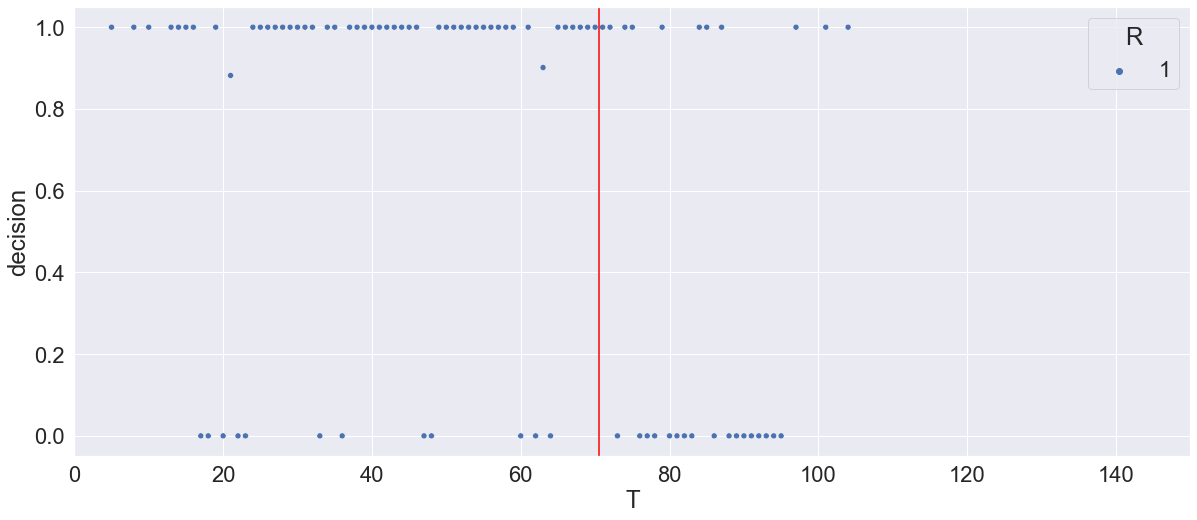

In [33]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==1])
g.set(xlim=(0, 150))
plt.axvline(70.5, 0,1,color='red')


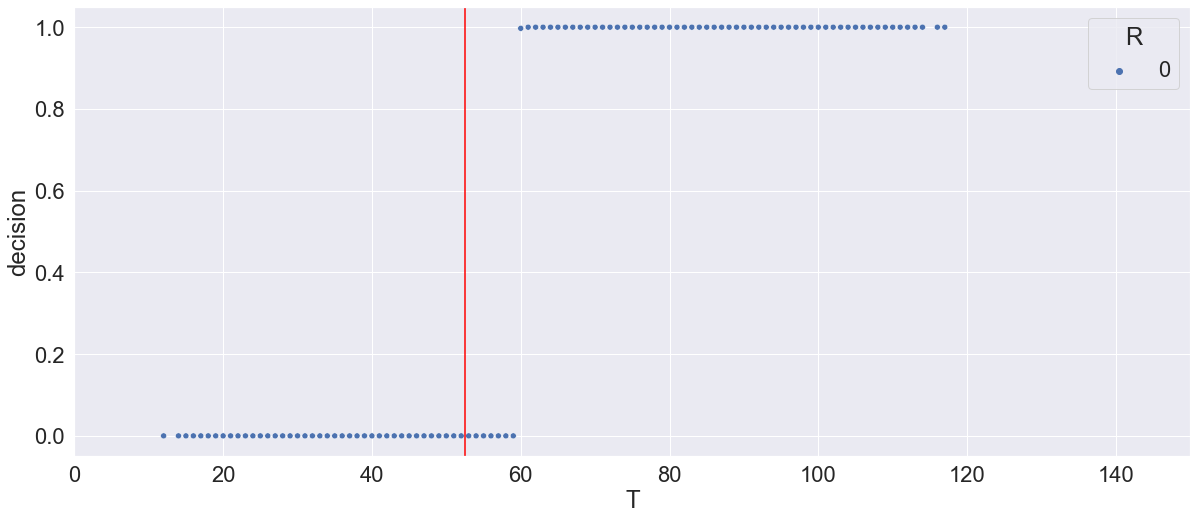

In [34]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==0])
g.set(xlim=(0, 150))
plt.axvline(52.5, 0,1,color='red')



In [35]:
admit_decisions[admit_decisions['decision']==0][['R_x','B_p']].groupby(['R_x']).mean()

,B_p
R_x,
0,0.379171
1,0.377762


In [36]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.5497837287293508', '25016.999999999993')

In [37]:
SUM_BP_POLICY/(FRAC_ADMIT*len(df))

0.5003399999999999

In [38]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.5497837287293508', '25016.999999999993')

In [39]:
admit_decisions[admit_decisions['decision']==1]['B_p'].mean()

0.49491567979244255

In [40]:
(admit_decisions['decision'] * admit_decisions['ml_outcomes_x']).sum()

32160.311099310125

In [41]:
(admit_decisions['decision'] * admit_decisions['B_p']).sum()

25016.999999999993

In [42]:
admit_decisions[admit_decisions['decision']==1]['B_p'].sum()

23654

In [43]:
(admit_decisions['decision'] * admit_decisions['B_p']).sum()/(len(admit_decisions)*FRAC_ADMIT)

0.5003399999999999

In [44]:
(admit_decisions['decision'].sum())

49999.99999999999

In [45]:
admit_decisions['rand'] = pd.Series([random.random() for x in range(0,len(admit_decisions))])
admit_decisions['dec_binary'] = admit_decisions['rand'] < admit_decisions['decision']


In [46]:
admit_decisions[admit_decisions['dec_binary']==0][['R_x','B_p']].groupby(['R_x']).mean()

,B_p
R_x,
0,0.379176
1,0.379607


In [47]:
admit_decisions['R_x'].value_counts()

0    66810
1    33190
Name: R_x, dtype: int64